# Elo world 

In this kernel, I build a LGBM model that aggregates the `new_merchant_transactions.csv` and `historical_transactions.csv` tables to the main train table. New features are built by successive grouping on`card_id` and `month_lag`, in order to recover some information from the time serie.

## Notebook  Content
1. [Loading the data](#1)
1. [Feature engineering](#2)
1. [Training the model](#3)
1. [Feature importance](#4)
1. [Submission](#5)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)

<a id="1"></a> <br>
## 1. Loading the data

First, we load the `new_merchant_transactions.csv` and `historical_transactions.csv`. In practice, these two files contain the same variables and the difference between the two tables only concern the position with respect to a reference date.  Also, booleans features are made numeric:

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
sample = pd.read_csv('../input/new_merchant_transactions.csv.zip',nrows=10)
dtypes = sample.dtypes

col_types = {}
remap = {np.int64: np.int16, np.float64:np.float16}
for column,typ in dtypes.items():
    col_types[column] = remap.get(typ.type,typ.type)

col_types


{'authorized_flag': numpy.object_,
 'card_id': numpy.object_,
 'city_id': numpy.int16,
 'category_1': numpy.object_,
 'installments': numpy.int16,
 'category_3': numpy.object_,
 'merchant_category_id': numpy.int16,
 'merchant_id': numpy.object_,
 'month_lag': numpy.int16,
 'purchase_amount': numpy.float16,
 'purchase_date': numpy.object_,
 'category_2': numpy.float16,
 'state_id': numpy.int16,
 'subsector_id': numpy.int16}

In [ ]:
new_transactions = pd.read_csv('../input/new_merchant_transactions.csv.zip', parse_dates=['purchase_date'],dtype=col_types)
historical_transactions = pd.read_csv('../input/historical_transactions.csv.zip', parse_dates=['purchase_date'],dtype=col_types)

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0}).astype(np.int8)
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

We then load the main files, formatting the dates and extracting the target:

In [5]:
historical_transactions.memory_usage()

Index                          80
authorized_flag          29112361
card_id                 232898888
city_id                  58224722
category_1               29112361
installments             58224722
category_3              232898888
merchant_category_id     58224722
merchant_id             232898888
month_lag                58224722
purchase_amount          58224722
purchase_date           232898888
category_2               58224722
state_id                 58224722
subsector_id             58224722
dtype: int64

In [6]:
new_transactions.memory_usage()

Index                         80
authorized_flag          1963031
card_id                 15704248
city_id                  3926062
category_1               1963031
installments             3926062
category_3              15704248
merchant_category_id     3926062
merchant_id             15704248
month_lag                3926062
purchase_amount          3926062
purchase_date           15704248
category_2               3926062
state_id                 3926062
subsector_id             3926062
dtype: int64

In [7]:
# from sklearn.preprocessing import LabelEncoder

# card_encoder = LabelEncoder()

# card_encoder.fit(np.hstack([historical_transactions.card_id,new_transactions.card_id]))



# historical_transactions.card_id = card_encoder.transform(historical_transactions.card_id).astype(np.int16)

# new_transactions.card_id = card_encoder.transform(new_transactions.card_id).astype(np.int16)

# merchant_encoder = LabelEncoder()

# merchant_encoder.fit(np.hstack([historical_transactions.merchant_id.fillna(""),new_transactions.merchant_id.fillna("")]))

# historical_transactions.merchant_id = card_encoder.transform(historical_transactions.merchant_id.fillna("")).astype(np.int16)

# new_transactions.merchant_id = card_encoder.transform(new_transactions.merchant_id.fillna("")).astype(np.int16)

In [8]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df
#_________________________________________
train = read_data('../input/train.csv.zip')
test = read_data('../input/test.csv.zip')

target = train['target']
del train['target']

In [9]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['sum', 'mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 1415.95 Mb (-6.2% reduction)
Mem. usage decreased to 84.24 Mb (6.2% reduction)


In [10]:
historical_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
115,0,C_ID_4e6213e9bc,88,0,0,842,M_ID_22c9cfa265,-10,-0.730469,2017-04-07 12:58:09,16,37,1,0,0,0,0,1,0,0
132,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723633,2017-09-17 22:40:27,16,16,1,0,0,0,0,1,0,0
148,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723633,2017-09-17 22:40:26,16,16,1,0,0,0,0,1,0,0
168,0,C_ID_4e6213e9bc,333,0,0,605,M_ID_c2ae34c2ef,0,-0.664062,2018-02-20 10:57:50,9,2,1,0,0,0,0,1,0,0
213,0,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-7,-0.738281,2017-07-08 07:33:31,16,34,1,0,0,0,0,1,0,0


<a id="2"></a> <br>
## Feature engineering
First, following [Robin Denz](https://www.kaggle.com/denzo123/a-closer-look-at-date-variables) analysis, I define a few dates features:

In [11]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

Then I define two functions that aggregate the info contained in these two tables. The first function aggregates the function by grouping on `card_id`:

In [12]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max']
        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [13]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,...,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_month_lag_min,hist_month_lag_max
0,C_ID_00007093c1,35,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,...,3,1,0.667367,5.914286,12,1,3.071419,28858113.0,-11,0
1,C_ID_0001238066,3,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,...,1,1,0.000000,8.666667,12,2,5.773503,3609150.0,-2,0
2,C_ID_0001506ef0,4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,...,1,0,0.500000,5.500000,12,2,4.725816,22098875.0,-8,0
3,C_ID_0001793786,27,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,...,1,0,0.395847,6.481481,9,3,2.375684,16780236.0,-7,-1
4,C_ID_000183fdda,7,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,...,6,1,2.288689,8.285714,10,8,0.755929,6701589.0,-6,-4


In [14]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,...,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_month_lag_min,auth_month_lag_max
0,C_ID_00007093c1,114,24.0,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,...,6,1,0.795159,6.517544,12,1,3.371490,32627654.0,-12,0
1,C_ID_0001238066,120,2.0,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,...,10,-1,1.501050,7.275000,12,1,4.895483,13110825.0,-5,0
2,C_ID_0001506ef0,62,0.0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,...,0,0,0.000000,6.887097,12,1,4.538017,34460275.0,-13,0
3,C_ID_0001793786,189,0.0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,...,0,0,0.000000,6.698413,10,1,2.301491,24487497.0,-9,0
4,C_ID_000183fdda,137,4.0,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,...,10,-1,2.108912,6.810219,12,1,4.538289,15148616.0,-5,0


In [15]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,...,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_month_lag_min,new_month_lag_max
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,...,1,1,0.000000,4.000000,4,4,0.000000,537024.0,2,2
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,...,10,-1,2.079941,3.346154,4,3,0.485165,5195343.0,1,2
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,...,0,0,0.000000,3.000000,3,3,0.000000,471152.0,1,1
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,...,0,0,0.000000,11.322581,12,11,0.475191,3981096.0,1,2
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,...,4,-1,1.293340,3.272727,4,3,0.467099,5106807.0,1,2


The second function first aggregates on the two variables `card_id` and `month_lag`. Then a second grouping is performed to aggregate over time:

In [16]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(historical_transactions) 
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,...,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-5.500000,3.605551,2.916667,1.621354,-1.200375,0.999104,-0.431963,0.260445,-0.613841,...,3.750000,3.107908,1.176389,0.326634,1.000000,0.000000,1.500000,0.797724,0.355262,0.480551
1,C_ID_0001238066,-1.000000,1.414214,1.500000,0.707107,-0.895020,0.421916,-0.596680,0.000000,-0.596680,...,1.500000,0.707107,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,NaN
2,C_ID_0001506ef0,-3.333333,4.163332,1.333333,0.577350,-0.968587,0.395519,-0.731038,0.015935,-0.732422,...,0.333333,0.577350,0.166667,0.288675,0.000000,0.000000,0.333333,0.577350,0.707107,NaN
3,C_ID_0001793786,-3.833333,2.316607,4.500000,1.974842,-1.970886,2.036743,-0.423529,0.392097,-0.676595,...,0.833333,0.983192,0.291667,0.400520,0.166667,0.408248,0.500000,0.547723,0.179558,0.279244
4,C_ID_000183fdda,-5.000000,1.414214,3.500000,3.535534,-0.470703,0.344576,-0.376099,0.478367,-0.579590,...,9.500000,12.020815,2.000000,1.414214,1.000000,0.000000,3.500000,3.535534,2.366432,NaN
5,C_ID_00024e244b,-5.000000,4.000000,2.428571,1.397276,-1.186593,1.210602,-0.558088,0.326255,-0.607265,...,0.714286,1.112697,0.297619,0.419041,0.142857,0.377964,0.428571,0.534522,0.269338,0.312603
6,C_ID_0002709b5a,-7.250000,5.057997,1.500000,1.000000,-0.929565,0.699099,-0.604126,0.156594,-0.616821,...,2.750000,2.362908,2.250000,2.500000,2.250000,2.500000,2.250000,2.500000,0.000000,NaN
7,C_ID_00027503e2,-4.000000,2.915476,3.600000,1.516575,-2.669629,1.128329,-0.741243,0.002491,-0.742969,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-6.500000,3.535534,1.000000,0.000000,-0.618164,0.093913,-0.618164,0.093913,-0.618164,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
9,C_ID_0002ba3c2e,-3.666667,3.559026,2.500000,1.516575,-1.547567,0.910322,-0.641756,0.080454,-0.656006,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<a id="3"></a> <br>
## 3. Training the model
We now train the model with the features we previously defined. A first step consists in merging all the dataframes:

In [17]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

and to define the features we want to keep to train the model:

In [18]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]

We then set the hyperparameters of the LGBM model:

In [19]:
param = {'num_leaves': 100,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': 6,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

We now train the model. Here, we use a standard KFold split of the dataset in order to validate the results and to stop the training. Interstingly, during the writing of this kernel, the model was enriched adding new features, which improved the CV score. The variations observed on the CV were found to be quite similar to the variations on the LB: it seems that the current competition won't give us headaches to define the correct validation scheme:

[100]	training's rmse: 3.73189	valid_1's rmse: 3.80368
[200]	training's rmse: 3.66231	valid_1's rmse: 3.7642
[300]	training's rmse: 3.60937	valid_1's rmse: 3.74222
[400]	training's rmse: 3.56657	valid_1's rmse: 3.72914
[500]	training's rmse: 3.53124	valid_1's rmse: 3.71978
[600]	training's rmse: 3.50034	valid_1's rmse: 3.71314
[700]	training's rmse: 3.47417	valid_1's rmse: 3.70879
[800]	training's rmse: 3.45003	valid_1's rmse: 3.70509
[900]	training's rmse: 3.42815	valid_1's rmse: 3.70201
[1000]	training's rmse: 3.40843	valid_1's rmse: 3.69991
[1100]	training's rmse: 3.39036	valid_1's rmse: 3.69779
[1200]	training's rmse: 3.37261	valid_1's rmse: 3.6965
[1300]	training's rmse: 3.35609	valid_1's rmse: 3.69522
[1400]	training's rmse: 3.34091	valid_1's rmse: 3.69422
[1500]	training's rmse: 3.32587	valid_1's rmse: 3.69368
[1600]	training's rmse: 3.31172	valid_1's rmse: 3.69307
[1700]	training's rmse: 3.29819	valid_1's rmse: 3.69317
[1800]	training's rmse: 3.28459	valid_1's rmse: 3.69287
[1900]	training's rmse: 3.27247	valid_1's rmse: 3.69291
[2000]	training's rmse: 3.26032	valid_1's rmse: 3.69269
[2100]	training's rmse: 3.24824	valid_1's rmse: 3.69263
[2200]	training's rmse: 3.23716	valid_1's rmse: 3.69267
[2300]	training's rmse: 3.22596	valid_1's rmse: 3.6925
[2400]	training's rmse: 3.21528	valid_1's rmse: 3.69262
Early stopping, best iteration is:
[2287]	training's rmse: 3.22732	valid_1's rmse: 3.69243
fold n°1

In [20]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.74992	valid_1's rmse: 3.80833
[200]	training's rmse: 3.69525	valid_1's rmse: 3.77122
[300]	training's rmse: 3.65707	valid_1's rmse: 3.74807
[400]	training's rmse: 3.62869	valid_1's rmse: 3.73129
[500]	training's rmse: 3.60644	valid_1's rmse: 3.71988
[600]	training's rmse: 3.58927	valid_1's rmse: 3.71261
[700]	training's rmse: 3.57633	valid_1's rmse: 3.70776
[800]	training's rmse: 3.56475	valid_1's rmse: 3.70425
[900]	training's rmse: 3.55407	valid_1's rmse: 3.70126
[1000]	training's rmse: 3.54477	valid_1's rmse: 3.69924
[1100]	training's rmse: 3.53561	valid_1's rmse: 3.6976
[1200]	training's rmse: 3.52681	valid_1's rmse: 3.69602
[1300]	training's rmse: 3.5189	valid_1's rmse: 3.69485
[1400]	training's rmse: 3.51073	valid_1's rmse: 3.69406
[1500]	training's rmse: 3.50238	valid_1's rmse: 3.69331
[1600]	training's rmse: 3.49508	valid_1's rmse: 3.69294
[1700]	training's rmse: 3.48775	valid_1's rmse: 3.69

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.76497	valid_1's rmse: 3.7388
[200]	training's rmse: 3.70859	valid_1's rmse: 3.70762
[300]	training's rmse: 3.66967	valid_1's rmse: 3.68842
[400]	training's rmse: 3.64078	valid_1's rmse: 3.67415
[500]	training's rmse: 3.61864	valid_1's rmse: 3.66541
[600]	training's rmse: 3.60064	valid_1's rmse: 3.65894
[700]	training's rmse: 3.58662	valid_1's rmse: 3.65534
[800]	training's rmse: 3.57414	valid_1's rmse: 3.65265
[900]	training's rmse: 3.56283	valid_1's rmse: 3.65039
[1000]	training's rmse: 3.55252	valid_1's rmse: 3.64848
[1100]	training's rmse: 3.54329	valid_1's rmse: 3.6471
[1200]	training's rmse: 3.53449	valid_1's rmse: 3.64584
[1300]	training's rmse: 3.52628	valid_1's rmse: 3.64512
[1400]	training's rmse: 3.51797	valid_1's rmse: 3.64437
[1500]	training's rmse: 3.51006	valid_1's rmse: 3.64377
[1600]	training's rmse: 3.50213	valid_1's rmse: 3.64341
[1700]	training's rmse: 3.49494	valid_1's rmse: 3.64

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.77293	valid_1's rmse: 3.71006
[200]	training's rmse: 3.71771	valid_1's rmse: 3.67716
[300]	training's rmse: 3.67646	valid_1's rmse: 3.65678
[400]	training's rmse: 3.64584	valid_1's rmse: 3.64329
[500]	training's rmse: 3.62378	valid_1's rmse: 3.63465
[600]	training's rmse: 3.60568	valid_1's rmse: 3.62901
[700]	training's rmse: 3.59118	valid_1's rmse: 3.62495
[800]	training's rmse: 3.57873	valid_1's rmse: 3.62249
[900]	training's rmse: 3.56847	valid_1's rmse: 3.62128
[1000]	training's rmse: 3.55947	valid_1's rmse: 3.62044
[1100]	training's rmse: 3.55021	valid_1's rmse: 3.61974
[1200]	training's rmse: 3.54118	valid_1's rmse: 3.61888
[1300]	training's rmse: 3.53276	valid_1's rmse: 3.61859
[1400]	training's rmse: 3.52477	valid_1's rmse: 3.61832
[1500]	training's rmse: 3.51701	valid_1's rmse: 3.61841
[1600]	training's rmse: 3.50851	valid_1's rmse: 3.61812
[1700]	training's rmse: 3.50133	valid_1's rmse: 3.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.72327	valid_1's rmse: 3.91095
[200]	training's rmse: 3.6683	valid_1's rmse: 3.87507
[300]	training's rmse: 3.62856	valid_1's rmse: 3.85297
[400]	training's rmse: 3.59933	valid_1's rmse: 3.83899
[500]	training's rmse: 3.57614	valid_1's rmse: 3.82925
[600]	training's rmse: 3.55866	valid_1's rmse: 3.82351
[700]	training's rmse: 3.54436	valid_1's rmse: 3.82002
[800]	training's rmse: 3.53228	valid_1's rmse: 3.81725
[900]	training's rmse: 3.52193	valid_1's rmse: 3.81528
[1000]	training's rmse: 3.51255	valid_1's rmse: 3.81363
[1100]	training's rmse: 3.50477	valid_1's rmse: 3.81252
[1200]	training's rmse: 3.49681	valid_1's rmse: 3.81149
[1300]	training's rmse: 3.48895	valid_1's rmse: 3.81073
[1400]	training's rmse: 3.48119	valid_1's rmse: 3.81015
[1500]	training's rmse: 3.4737	valid_1's rmse: 3.80961
[1600]	training's rmse: 3.46635	valid_1's rmse: 3.80925
[1700]	training's rmse: 3.45986	valid_1's rmse: 3.80

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.76709	valid_1's rmse: 3.72973
[200]	training's rmse: 3.70996	valid_1's rmse: 3.69848
[300]	training's rmse: 3.67063	valid_1's rmse: 3.6796
[400]	training's rmse: 3.63983	valid_1's rmse: 3.66486
[500]	training's rmse: 3.61717	valid_1's rmse: 3.65587
[600]	training's rmse: 3.59818	valid_1's rmse: 3.64951
[700]	training's rmse: 3.58294	valid_1's rmse: 3.6455
[800]	training's rmse: 3.56996	valid_1's rmse: 3.64309
[900]	training's rmse: 3.55861	valid_1's rmse: 3.64151
[1000]	training's rmse: 3.5489	valid_1's rmse: 3.64048
[1100]	training's rmse: 3.53969	valid_1's rmse: 3.63959
[1200]	training's rmse: 3.53171	valid_1's rmse: 3.63903
[1300]	training's rmse: 3.52339	valid_1's rmse: 3.63849
[1400]	training's rmse: 3.51576	valid_1's rmse: 3.63809
[1500]	training's rmse: 3.50837	valid_1's rmse: 3.63791
[1600]	training's rmse: 3.50112	valid_1's rmse: 3.63762
[1700]	training's rmse: 3.49392	valid_1's rmse: 3.637

<a id="4"></a> <br>
## 4. Feature importance
Finally, we can have a look at the features that were used by the model:

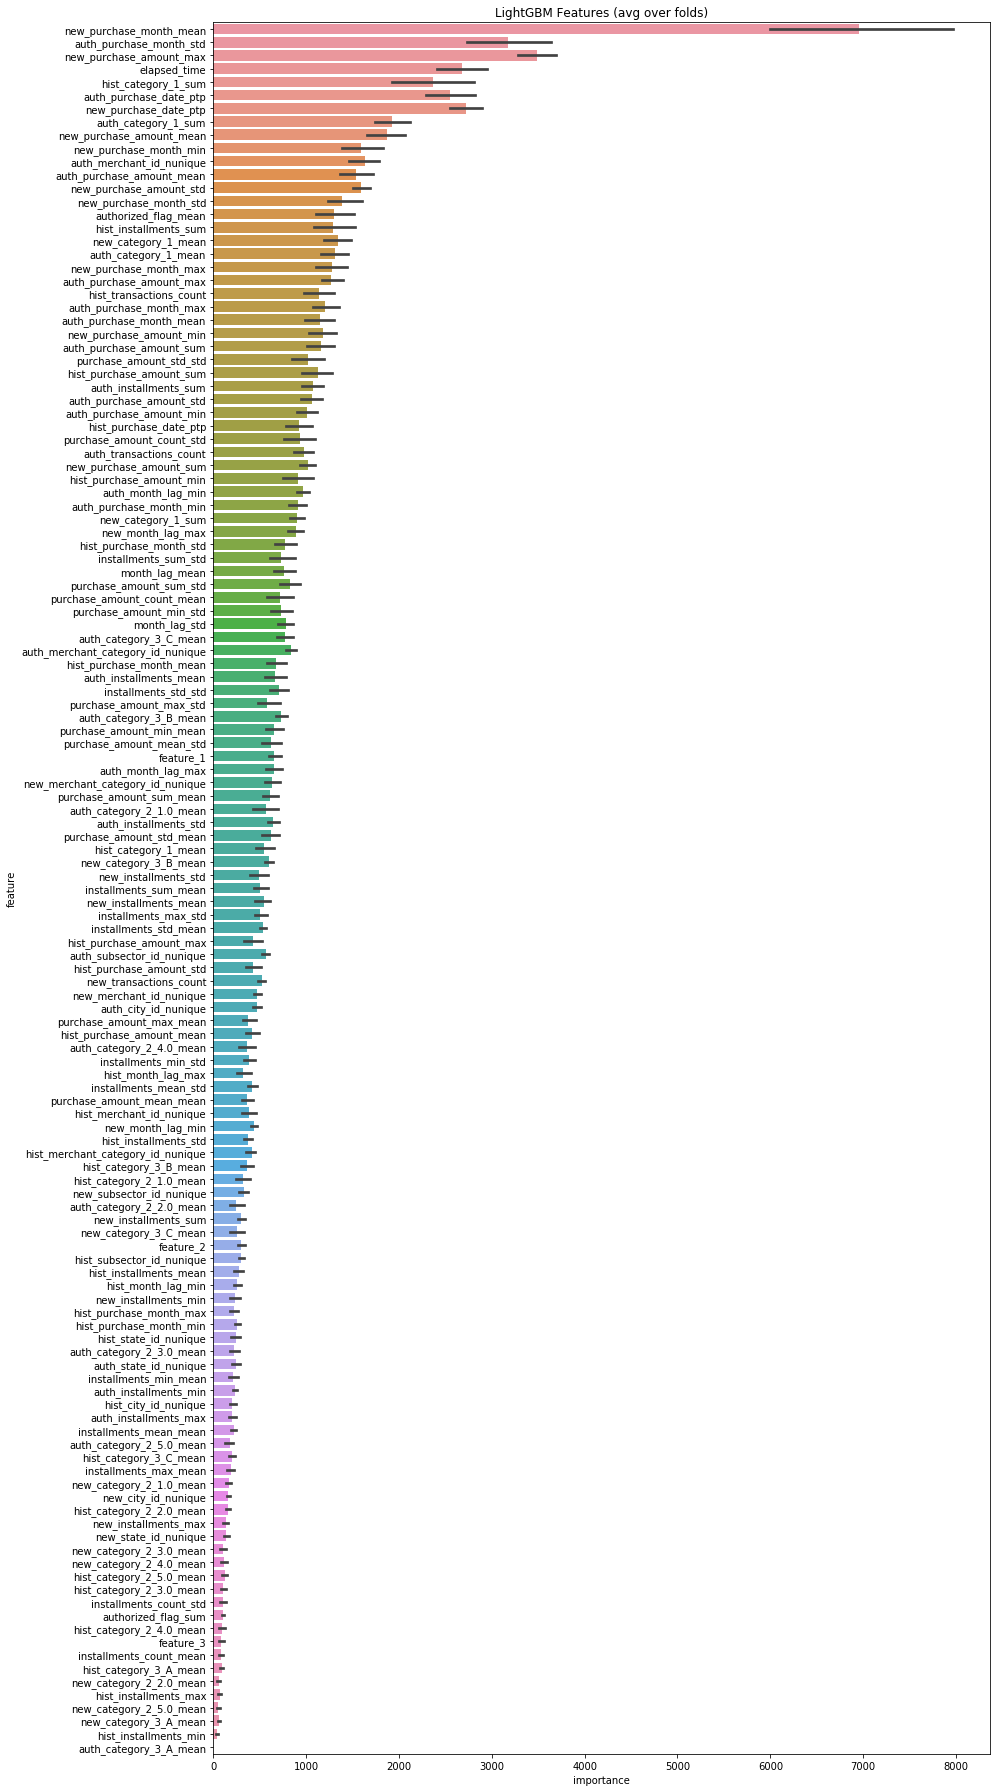

In [21]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

<a id="5"></a> <br>
## 5. Submission
Now, we just need to prepare the submission file:

In [22]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)

In [24]:
train.to_hdf("../input/train_elo_world.hd5","train")
test.to_hdf("../input/train_elo_world.hd5","test")
